In [1]:
# Install dependencies first, then restart the kernel.
%pip install nltk
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup, Tag, Comment
import xml.dom.minidom
import re

def convert_to_element(tag):
    if isinstance(tag, Tag):
        element = ET.Element(tag.name, tag.attrs)
        for child in tag.contents:
            if isinstance(child, Tag):
                sub_element = convert_to_element(child)
                element.append(sub_element)
            else:
                element.text = child
        return element
    else:
        return ET.Element(tag)

def extract_body(html):
    soup = BeautifulSoup(html, 'html.parser')

    # Remove whitespace nodes
    def remove_whitespace_nodes(node):
        if not isinstance(node, str):
            for child in node.contents:
                if isinstance(child, str) and len(child.strip()) == 0:
                    child.extract()
                else:
                    remove_whitespace_nodes(child)

    remove_whitespace_nodes(soup)

    # Remove script tags (JavaScript)
    for script in soup.find_all('script'):
        script.extract()
    for script in soup.find_all('noscript'):
        script.extract()

    # Remove style tags (CSS)
    for style in soup.find_all('style'):
        style.extract()

    # Remove comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    for comment in comments:
        comment.extract()
    
    # Remove SVG images because these have complex
    # drawing paths that we are not interested in
    for style in soup.find_all('svg'):
        style.extract()

    # For the same reason, discard Form and Input elements.
    for style in soup.find_all('form'):
        style.extract()
    for style in soup.find_all('input'):
        style.extract()

    # Extract body
    body = soup.body

    # Remove "class" attributes from all elements
    def remove_class_attributes(tag):
        #if tag.has_attr('class'):
        #    del tag['class']
        
        # Also remove data- attributes
        # and aria-, style CSS, IDs, and other noisy
        # attributes.
        for attr in list(tag.attrs):
            if not attr in ["alt", "title", "src", "href"]:
                del tag[attr]

            # Also remove empty keys
            elif tag[attr].strip() == "":
                del tag[attr]
            
        #    if attr.startswith('data-'):
        #        del tag[attr]
        #    elif attr.startswith('aria-'):
        #        del tag[attr]
        #    elif attr == 'style':
        #        del tag[attr]
        #    elif attr == 'id':
        #        del tag[attr]
        #    elif attr in ['height', 'loading', 'width', 'tabindex', 'dir', 'target', 'role', 'type']:
        #        del tag[attr]
        
        for child in tag.children:
            if isinstance(child, Tag):
                remove_class_attributes(child)

    remove_class_attributes(body)

    # Remove empty nodes
    def remove_empty_nodes(tag):
        children = tag.contents
        for child in children:
            if isinstance(child, Tag):
                if len(child.contents) > 0:
                    remove_empty_nodes(child)
                if len(child.contents) == 0 and len(child.attrs.keys()) == 0:
                    child.extract()

    remove_empty_nodes(body)
    
    # Convert body contents to XML
    xml = str(body)

    return xml


## Example usage of the extraction

In [3]:
html = '''
<html>
<head>
    <title>Example HTML</title>
    <style>
        body {
            background-color: #f0f0f0;
        }
    </style>
</head>
<body>
    <h1 class="heading">Hello, world!</h1>
    <p>This is an example HTML.</p>
    <div class="container" data-info="some-info" data-value="42">
        <p class="info">Some information</p>
        <p class="note">A note</p>
    </div><div><div><div></div></div></div>
    <script>
        alert('This is JavaScript');
    </script>
</body>
</html>
'''

xml_output = re.sub('>\n+<', '><', extract_body(html))


dom = xml.dom.minidom.parseString(xml_output)
formatted_xml = dom.toprettyxml(indent='  ')

print(formatted_xml)

<?xml version="1.0" ?>
<body>
  <h1>Hello, world!</h1>
  <p>This is an example HTML.</p>
  <div>
    <p>Some information</p>
    <p>A note</p>
  </div>
</body>



# Sample Yahoo Site Data starts here.

We are going to use this as a starting point to process all the other HTML data that we downloaded as part of the dataset, into a "clean" representation which can then be converted into a tokenized representation for Machine Learning, or it can be coupled with other cross-domain data using a Template Rule.

In [4]:
with open("../data/yahoo.com.html") as f:
    yahoo_html = f.read()

xml_output = extract_body(yahoo_html)
#print(xml_output[335671-100:335671+100])

dom = xml.dom.minidom.parseString(xml_output)
formatted_xml = dom.toprettyxml(indent='  ')

#print(formatted_xml)

# Data Tokenization

To tokenize the XML content into words using the xml.dom.minidom module, you can extract the text content from the DOM nodes and then tokenize the text using appropriate techniques. 

## Punkt tokenizer

The Punkt tokenizer is a pre-trained unsupervised machine learning tokenizer available in the NLTK (Natural Language Toolkit) library. It is designed specifically for tokenizing natural language text, capable of handling various punctuation patterns and ambiguous word boundaries. It uses a combination of unsupervised and supervised learning techniques to determine sentence boundaries and word tokenization, and has been trained on large corpora and can handle a wide range of languages and text genres.

Punkt is a widely used and reliable tool for tokenizing natural language text in many NLP (Natural Language Processing) tasks, including text analysis, information retrieval, and machine learning algorithms that require tokenized input, but it must be downloaded first:

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Code for tokenizing the XML
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def extract_text_from_tags(dom):
    extracted_text = ''

    def extract_text(node):
        nonlocal extracted_text

        if node.nodeType == node.TEXT_NODE:
            extracted_text += ' ' + node.data.strip()
        elif node.nodeType == node.ELEMENT_NODE:
            if node.tagName == 'img':
                if node.hasAttribute('alt'):
                    extracted_text += ' ' + node.getAttribute('alt')
            if node.hasAttribute('title'):
                extracted_text += ' ' + node.getAttribute('title')

            for child in node.childNodes:
                extract_text(child)

    body = dom.documentElement
    for child in body.childNodes:
        extract_text(child)

    return extracted_text.strip()

tokenized_text = nltk.word_tokenize(extract_text_from_tags(dom))
# Remove tokens with symbols using regular expressions
tokenized_text = [token for token in tokenized_text if re.match(r'^[-a-zA-Z0-9]+$', token)]

# Remove tokens that are entirely numbers
tokenized_text = [token for token in tokenized_text if not token.isdigit()]

# Remove tokens that are one character long
tokenized_text = [token for token in tokenized_text if len(token) > 1]

# Define common stopwords/conjunctions/pronouns
stopwords_list = set(stopwords.words('english'))

# Remove common stopwords
tokenized_text = [token for token in tokenized_text if token.lower() not in stopwords_list]

# Convert titlecase tokens to lowercase, except for ALL CAPS tokens
tokenized_text = [token.lower() if not token.isupper() else token for token in tokenized_text]

## Token vectorizers

At this point, we have a choice between two machine learning algorithms for classifying the data - we can use Bag of Words which just counts the frequency of the terms in the documet, or we can use TF/IDF which stands for *Term Frequency times the Inverse Document Frequency* (the "IDF" being the *inverse* of the number of times the term appears in the document).

TF/IDF is more readily compared between different documents and so this is the metric that we will settle with. We will consider only terms with a frequency of 0.25 or greater.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

threshold = 0.25
# Calculate TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform([" ".join(tokenized_text)])

# Get top tokens according to the threshold and TF-IDF scores
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
input_data = [x for x in zip(feature_names_tfidf, tfidf.toarray()[0]) if x[1] >= 0.25]
top_tokens_tfidf = sorted(input_data, key=lambda x: x[1], reverse=True)
print(f"\nTop tokens (TF-IDF):")
for token, score in top_tokens_tfidf:
    print(f"{token}: {score}")


Top tokens (TF-IDF):
feedback: 0.5252794262274542
thanks: 0.5252794262274542
sports: 0.30585890641092267
yahoo: 0.25931515978317354


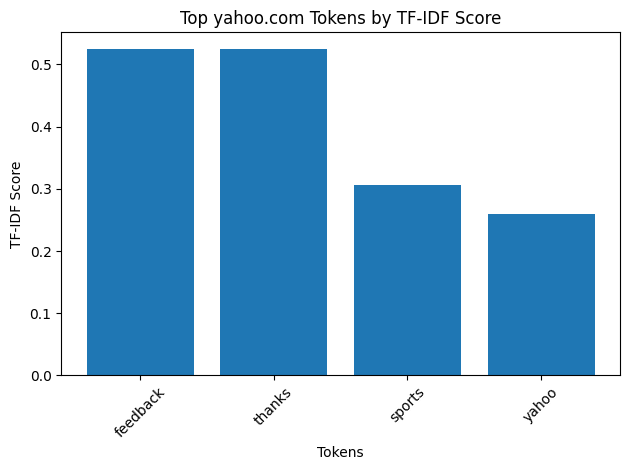

In [9]:
import matplotlib.pyplot as plt

# Extract tokens and scores in one line
tokens, scores = zip(*top_tokens_tfidf)

# Plot the TF-IDF scores
plt.bar(tokens, scores)
plt.xlabel('Tokens')
plt.ylabel('TF-IDF Score')
plt.title('Top yahoo.com Tokens by TF-IDF Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()